In [387]:
%load_ext autoreload
%autoreload 1
%aimport dlqmc.NN, dlqmc.Sampler, dlqmc.Examples
%aimport dlqmc.utils, dlqmc.sampling, dlqmc.analysis, dlqmc.gto, dlqmc.physics
%config InlineBackend.figure_format = 'svg' 
%config InlineBackend.print_figure_kwargs = {'bbox_inches': 'tight', 'dpi': 300}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [388]:
import numpy as np
from scipy import special
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, RandomSampler
from torch.distributions import Normal
from pyscf import gto, scf
from pyscf.data.nist import BOHR
from tqdm import tqdm_notebook, tnrange

from dlqmc.NN import WaveNet
from dlqmc.Sampler import HMC
from dlqmc.Examples import Potential, Laplacian, Gradient, fit
from dlqmc.sampling import langevin_monte_carlo
from dlqmc.utils import plot_func, get_3d_cube_mesh, assign_where
from dlqmc.physics import local_energy, grad, quantum_force
from dlqmc.gto import wf_from_mf
from dlqmc.analysis import autocorr, blocking

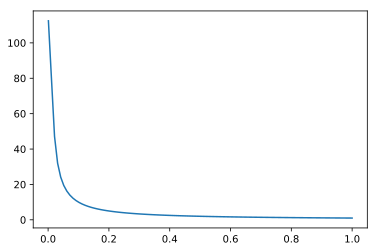

In [389]:
plot_func(np.linspace(1e-3, 1, 100), lambda x: special.erf(x/0.01)/x);

In [4]:
coords = torch.Tensor([[-1, 0, 0], [1, 0, 0]])
charges = torch.Tensor([1, 1])
x_line = torch.cat((torch.linspace(-3, 3, 500)[:, None], torch.zeros((500, 2))), dim=1)
mesh = get_3d_cube_mesh([(-6, 6), (-4, 4), (-4, 4)], [600, 400, 400])

In [5]:
mol = gto.M(
    atom=[
        ['H', (-1, 0, 0)],
        ['H', (1, 0, 0)]
    ],
    unit='bohr',
    basis='aug-cc-pv5z',
    charge=1,
    spin=1,
)
mf = scf.RHF(mol)
mf.kernel()

converged SCF energy = -0.60262227147977


-0.6026222714797702

## Net WF

In [4]:
#H2+     Energy = -0.6023424   for R = 1.9972
#fit(batch_size=10000, n_el=1, steps=500, epochs=1, RR=[[-1, 0, 0], [1., 0, 0]])

#H2		 Energy = -1.173427    for R = 1.40
#fit(batch_size=10000,n_el=2,steps=100,epochs=5,RR=torch.tensor([[-0.7,0,0],[0.7,0,0]]))

#He+	 Energy = -1.9998
#fit(batch_size=10000,n_el=1,steps=100,epochs=5,RR=torch.tensor([[0.,0,0]]),RR_charges=[2])

#He		 Energy = −2.90338583
#fit(batch_size=10000,n_el=2,steps=300,epochs=5,RR=torch.tensor([[0.3,0,0]]),RR_charges=[2])

In [5]:
lr = 5e-3

In [58]:
net = WaveNet([2, 20, 20, 20, 1], eps=0.01)
opt = torch.optim.Adam(net.parameters(), lr=lr)
tape = []
for i_step in tnrange(0, 1_000):
    r = 3*torch.randn(10_000, 3)
    grad_psi, psi = Gradient(r, coords, net)
    V = Potential(r, coords, charges)
    loss = torch.sum(0.5*torch.sum(grad_psi**2, dim=1) + V*psi**2)/torch.sum(psi**2)
    with torch.autograd.no_grad():
        tape.append((i_step, loss.item(), net(x_line, coords).squeeze()))
    loss.backward()
    opt.step()
    opt.zero_grad()

NameError: name 'lr' is not defined

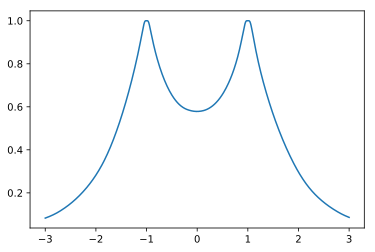

In [10]:
plt.plot(x_line[:, 0].numpy(), -net(x_line, coords).detach().numpy());

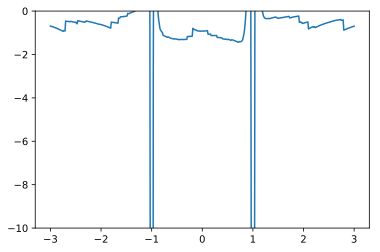

In [29]:
plt.plot(
    x_line[:, 0].numpy(),
    local_energy(lambda x: net(x, coords), x_line, coords, charges).detach().numpy()
)
plt.ylim((-10, 0));

In [30]:
samples = HMC_ad(
    dist=lambda x: net(x, coords).squeeze()**2,
    stepsize=0.1,
    dysteps=3,
    n_walker=100,
    steps=5000,
    dim=3,
    push=1,
    startfactor=1,
    presteps=50,
).detach().reshape(-1, 3)

Acceptanceratio: 87.12%


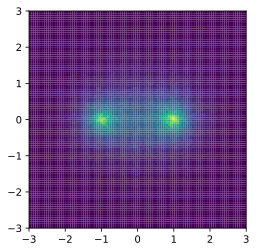

In [31]:
plt.hist2d(
    samples[:, 0].numpy(),
    samples[:, 1].numpy(),
    bins=100,
    range=[[-3, 3], [-3, 3]],
)                                   
plt.gca().set_aspect(1)

In [32]:
E_loc = local_energy(lambda x: net(x, coords), samples, coords, charges)

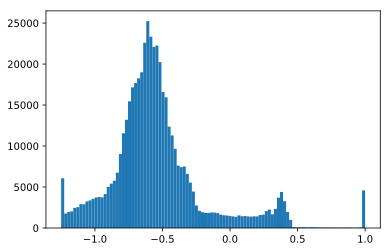

In [33]:
plt.hist(E_loc.detach().clamp(-1.25, 1).numpy(), bins=100);

In [35]:
E_loc.mean().item()

-0.5168347954750061

## GTO WF

In [6]:
mol = gto.M(
    atom=[
        ['H', (-1, 0, 0)],
        ['H', (1, 0, 0)]
    ],
    unit='bohr',
    basis='6-311g',
    charge=1,
    spin=1,
)
mf = scf.RHF(mol)
scf_energy = mf.kernel()

converged SCF energy = -0.590478992645745


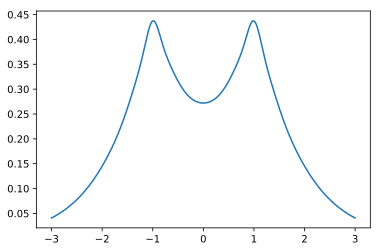

In [7]:
plt.plot(
    x_line[:, 0].numpy(),
    wf_from_mf(x_line, mf, 0).detach().numpy()
);

In [8]:
# (wf_from_mf(mesh, mf, 0)**2).sum()*(12*8*8/mesh.shape[0])

tensor(0.9920)

(-10, 0)

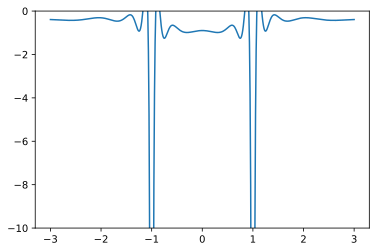

In [8]:
plt.plot(
    x_line[:, 0].numpy(),
    local_energy(
        x_line,
        lambda x: wf_from_mf(x, mf, 0),
        coords,
        charges,
    ).detach().numpy()
)
plt.ylim((-10, 0))

In [367]:
samples = HMC(
    dist=lambda x: wf_from_mf(x, mf, 0)**2,
    stepsize=np.sqrt(0.1),
    dysteps=0,
    n_walker=100,
    steps=5000,
    dim=3,
    startfactor=1,
    presteps=100,
).detach().transpose(0, 1).contiguous()

100%|██████████| 5100/5100 [00:26<00:00, 195.31it/s]


Acceptanceratio: 80.29%


In [390]:
tau = 0.1
n_walker = 100
n_steps = 5000
samples, info = langevin_monte_carlo(lambda x: wf_from_mf(x, mf, 0), n_walker, n_steps, tau, range=tnrange)
info

{'acceptance': 0.977768}

In [391]:
E_loc = local_energy(
    samples.view(-1, 3), lambda x: wf_from_mf(x, mf, 0), coords, charges
).view(100, -1)

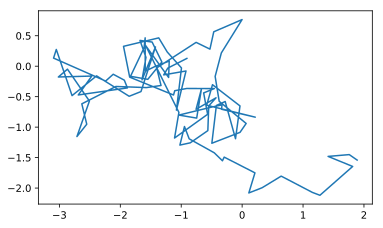

In [393]:
plt.plot(*samples[0][:100, :2].numpy().T)
plt.gca().set_aspect(1)

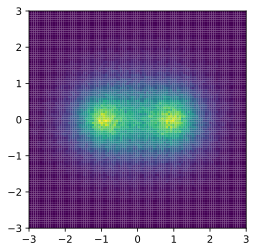

In [394]:
plt.hist2d(
    *samples.view(-1, 3)[:, :2].numpy().T,
    bins=100,
    range=[[-3, 3], [-3, 3]],
)                                   
plt.gca().set_aspect(1)

(-0.7, -0.5)

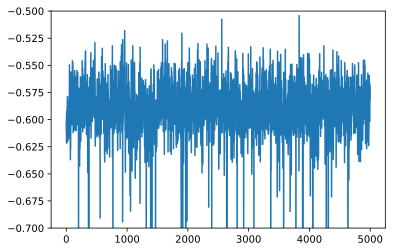

In [395]:
plt.plot(E_loc.mean(0).numpy())
plt.ylim(-0.7, -0.5)

In [396]:
E_loc.mean()

tensor(-0.5899)

In [397]:
E_loc.std()

tensor(0.3060)

In [398]:
E_loc.std().item()/np.sqrt(n_walker*n_steps)

0.0004327820058015681

In [399]:
(E_loc.mean(dim=-1).std()*np.sqrt(5000)/E_loc.std())**2

tensor(3.1470)

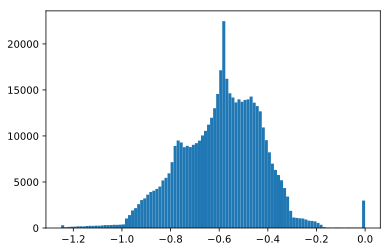

In [400]:
plt.hist(E_loc.flatten().clamp(-1.25, 0).numpy(), bins=100);

In [401]:
scf_energy, E_loc.mean().item(), (E_loc.mean(dim=-1).std()/np.sqrt(100)).item()

(-0.5904789926457448, -0.5899466276168823, 0.0007677451940253377)

In [402]:
results = ([], [])
with open('/storage/mi/jhermann/Research/Projects/nqmc/_dev/test-calc-2/h2+-hf-vmc.qw.log') as f:
    for l in f:
        words = l.split()
        if words and words[0].startswith('total_energy'):
            i = 1 if words[0].endswith('var') else 0
            results[i].append(words[2])
results = torch.tensor(np.array(results, dtype=float).T)

In [135]:
avg = results[:, 0].mean()
avg

tensor(-0.5902, dtype=torch.float64)

In [136]:
avgvar = (results[:, 1].view(-1, 1).norm(dim=-1)).mean().item()
np.sqrt(avgvar)

0.3250514804846397

In [137]:
(results[:, 0].var() + results[:, 1].mean()).sqrt().item()

0.325348706875114

In [139]:
err = (results[:, 0].std(unbiased=False).item()/np.sqrt(500))**2
np.sqrt(err)

0.0006211754467984398

In [140]:
indep_points = avgvar/err
indep_points

273826.6635503522

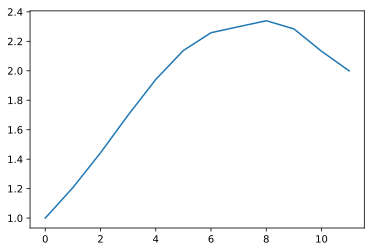

In [403]:
plt.plot(*np.array(list(map(blocking, E_loc))).mean(0).T)

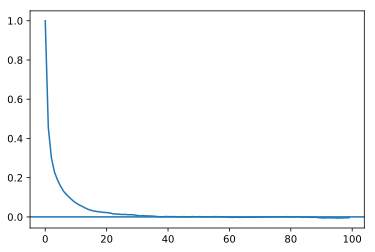

In [404]:
plt.plot(np.array(list(map(lambda x: autocorr(range(100), x), E_loc))).mean(0))
plt.axhline()